# Utilizado para realizar pruebas

Es la primera aproximación a resolver: ¿Se va a tardar menos de 4 días en alquilar?, el F1 Score que daba era muy bajo, posiblemente por falta de datos. Se abandona la idea y finalmente se hace regresión para calcular precio.

## Modelo para resolución del problema

Se va a aplicar un modelo supervisado de clasificación.

In [1]:
import geopandas as gpd
from io import StringIO
from IPython.display import Image
import matplotlib as mpl
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
#import pydotplus
import seaborn as sns

## Para el transformer BoolToNum
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, RandomForestRegressor
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz

ERROR 1: PROJ: proj_create_from_database: Open of /home/jose/miniconda3/envs/tdd_pra2/share/proj failed


La utilización del formato parquet permite leer los datos del fichero y a la vez los formatos de los campos sin necesidad de inferirlos, ya que quedan grabados en el propio fichero.

In [2]:
alquiler = pd.read_parquet("../data/madrid-rent-prices_4-8_cleaned.parquet")
alquiler.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1406 entries, 6 to 6952
Data columns (total 27 columns):
 #   Column                 Non-Null Count  Dtype          
---  ------                 --------------  -----          
 0   zipCode                1406 non-null   category       
 1   buildingSubtype        1406 non-null   category       
 2   clientTypeId           1406 non-null   category       
 3   dateOriginal           1406 non-null   datetime64[ns] 
 4   bathrooms              1406 non-null   int8           
 5   balcony                1406 non-null   int8           
 6   air_conditioner        1406 non-null   int8           
 7   heater                 1406 non-null   int8           
 8   heating                1406 non-null   int8           
 9   swimming_pool          1406 non-null   int8           
 10  parking                1406 non-null   int8           
 11  conservationState      1406 non-null   category       
 12  floor                  1406 non-null   int8     

De los datos leidos, se puede eliminar la variable _publishedDays_, ya que es redundante, esta variable contiene el número de días que ha estado publicado un anuncio eliminado, y tiene un significado equivalente a la variable target.
También se elimina la columna _dateOriginal_

In [3]:
alquiler.drop(['publishedDays','dateOriginal'], axis=1, inplace=True)

In [4]:
alquiler.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1406 entries, 6 to 6952
Data columns (total 25 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   zipCode                1406 non-null   category
 1   buildingSubtype        1406 non-null   category
 2   clientTypeId           1406 non-null   category
 3   bathrooms              1406 non-null   int8    
 4   balcony                1406 non-null   int8    
 5   air_conditioner        1406 non-null   int8    
 6   heater                 1406 non-null   int8    
 7   heating                1406 non-null   int8    
 8   swimming_pool          1406 non-null   int8    
 9   parking                1406 non-null   int8    
 10  conservationState      1406 non-null   category
 11  floor                  1406 non-null   int8    
 12  terrace                1406 non-null   int8    
 13  elevator               1406 non-null   int8    
 14  rooms                  1406 non-null   i

### Transformar zipCode en lat,lon

Para utilizar los códigos postales de forma efectiva en nuestro modelo los transformaremos a (latitud, longitud) del punto central al código postal.

https://stats.stackexchange.com/questions/94902/how-to-represent-geography-or-zip-code-in-machine-learning-model-or-recommender


In [5]:
madrid = gpd.read_file("../data/MADRID.geojson")
madrid.shape

(370, 5)

In [6]:
madrid = madrid[madrid.COD_POSTAL.str.startswith("280")]
madrid.shape

(55, 5)

In [7]:
# Antes de transformar a lat, lon hay que proyectar el polígono
center_zipCode = madrid['geometry'].to_crs(epsg=3857).centroid
madrid['lon'] = center_zipCode.x
madrid['lat'] = center_zipCode.y
madrid[:2]

,ID_CP,COD_POSTAL,ALTA_DB,CODIGO_INE,geometry,lon,lat
0,2.807900e+11,28008,2015-07-09,28079,"POLYGON ((-3.71876 40.43541, -3.71885 40.43479...",-414567.647802,4.928365e+06
7,2.807900e+11,28053,2015-07-09,28079,"POLYGON ((-3.66055 40.39356, -3.66069 40.39331...",-408226.884733,4.920329e+06


In [8]:
#Se han detectado códigos postales 28000 que no existen se transforman a 28001
print(alquiler.loc[alquiler.zipCode=="28000","zipCode"].shape)
alquiler.loc[alquiler.zipCode=="28000","zipCode"] = "28001"
print(alquiler.loc[alquiler.zipCode=="28000","zipCode"].shape)

(3,)
(0,)


In [9]:
madrid = madrid.set_index('COD_POSTAL')

# Incorporamos en alquiler lat, lon y eliminamos zipCode
alquiler = alquiler.join(madrid[['lon', 'lat']], on="zipCode")\
                   .drop('zipCode', axis=1)
alquiler[:3]

,buildingSubtype,clientTypeId,bathrooms,balcony,air_conditioner,heater,heating,swimming_pool,parking,conservationState,...,isPackPremiumPriority,isNewConstruction,isOpportunity,otherFeaturesCount,price,periodicityId,price_var,target,lon,lat
index,,,,,,,,,,,,,,,,,,,,,
6,Flat,Inmob.,2,0,1,0,0,0,0,Desconocido,...,True,False,False,3,1320.0,Mensual,0,False,-405434.834792,4.930403e+06
7,Flat,Inmob.,2,0,0,0,0,0,0,Desconocido,...,True,False,False,3,1190.0,Mensual,0,False,-410499.337677,4.922888e+06
22,Flat,Inmob.,2,0,1,1,0,0,0,Bueno,...,True,False,False,6,2100.0,Mensual,0,True,-411521.557939,4.929051e+06


### Revisión periodidicidad de pago

Una de las columnas es la periodicidad. Esta columna tiene la siguiente table de frecuencias

In [10]:
alquiler.periodicityId.value_counts()

Mensual        1405
Desconocido       1
Name: periodicityId, dtype: int64

Solo existe una fila con periodiciad _Desconocido_, vamos a ver sus datos y si encaja con una periodicidad de pago mensual, todas las filas tendrían en mismo valor, por tanto podríamos eliminar la variable

In [11]:
alquiler.loc[alquiler.periodicityId=="Desconocido",('surface','price')]

,surface,price
index,,
5359,55.0,745.8


Como se aprecia, cuadra perfectamente con un pago mensual de una renta, por lo que vamos a eliminar la columna.

In [12]:
alquiler.drop('periodicityId', axis=1, inplace=True)

### Separación en train y test

In [13]:
Xtrain, Xtest, ytrain, ytest = train_test_split(alquiler.loc[:,alquiler.columns!="target"], 
                                                alquiler.target, 
                                                test_size=0.1,
                                                stratify=alquiler.target)

Xtrain.shape, Xtest.shape, ytrain.shape, ytest.shape

((1265, 24), (141, 24), (1265,), (141,))

In [14]:
Xtrain.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1265 entries, 6308 to 6814
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   buildingSubtype        1265 non-null   category
 1   clientTypeId           1265 non-null   category
 2   bathrooms              1265 non-null   int8    
 3   balcony                1265 non-null   int8    
 4   air_conditioner        1265 non-null   int8    
 5   heater                 1265 non-null   int8    
 6   heating                1265 non-null   int8    
 7   swimming_pool          1265 non-null   int8    
 8   parking                1265 non-null   int8    
 9   conservationState      1265 non-null   category
 10  floor                  1265 non-null   int8    
 11  terrace                1265 non-null   int8    
 12  elevator               1265 non-null   int8    
 13  rooms                  1265 non-null   int8    
 14  surface                1265 non-null 

In [27]:
cat_cols = Xtrain.select_dtypes("category").columns.to_list()
num_cols = Xtrain.select_dtypes(["number", "bool"]).columns.to_list()
transformer = make_column_transformer(
    (OneHotEncoder(), cat_cols),
    (StandardScaler(), num_cols),
    remainder='passthrough')


pipe = Pipeline([
    ("boolToNum", BoolToNum()),
    ("transformer", transformer)
])

pipe.fit_transform(Xtrain)

array([[ 0.        ,  0.        ,  0.        , ...,  0.02403377,
        -0.98167478, -1.0431256 ],
       [ 0.        ,  0.        ,  0.        , ...,  0.02403377,
         0.09044355,  1.13919659],
       [ 0.        ,  0.        ,  0.        , ...,  0.02403377,
        -0.36894274, -0.14275646],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.02403377,
         0.27496339,  0.51480477],
       [ 1.        ,  0.        ,  0.        , ...,  0.02403377,
         0.18256481, -0.35523496],
       [ 0.        ,  0.        ,  1.        , ...,  0.02403377,
        -0.29539833,  0.11803633]])

### Construcción del pipeline


In [21]:
# Es una clase que se puede utilizar dentro de un pipeline para transformar 
# todas las col bool en numéricas.
class BoolToNum (BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X, y = None):
        _X = X.copy()
        for bcol in _X.select_dtypes("bool").columns.to_list():
            _X[bcol] = _X[bcol].replace({True: 1, False: 0})
        return _X

In [28]:
from sklearn.metrics import f1_score, make_scorer, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

def best_model(estimator, params, 
               Xtrain=Xtrain, ytrain=ytrain, 
               scoring="f1", return_train_score=False):

    cat_cols = Xtrain.select_dtypes("category").columns.to_list()
    num_cols = Xtrain.select_dtypes(["number", "bool"]).columns.to_list()
    transformer = make_column_transformer(
        (OneHotEncoder(), cat_cols),
        (StandardScaler(), num_cols),
        remainder='passthrough')


    pipe = Pipeline([
        ("boolToNum", BoolToNum()),
        ("transformer", transformer),
        ("estimator", estimator)
    ])

    #adapta params para el paso 'estimator' del pipeline
    params_ = {"estimator__"+k:v for k,v in params.items()}

    clf = GridSearchCV(estimator=pipe, 
                    param_grid=params_, 
                    cv=4,
                    return_train_score=return_train_score,
                    scoring=scoring)

    clf.fit(Xtrain, ytrain)

    print("Best parameters:")
    print(f"Métrica {clf.scoring}: {clf.best_score_:.2f}")
    print(f"Parámetros: {clf.best_params_}")
    return clf

In [29]:


params = {
    'learning_rate': [0.01, 0.1, 1, 2],
    'n_estimators': [10, 50, 100, 200]
}
clf_1_5 = best_model(GradientBoostingClassifier(), params)



Best parameters:
Métrica f1: 0.20
Parámetros: {'estimator__learning_rate': 1, 'estimator__n_estimators': 10}


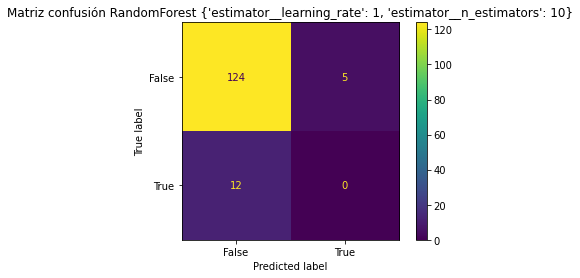

In [31]:


from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(clf_1_5, Xtest, ytest)
plt.title("Matriz confusión RandomForest {}".format(clf_1_5.best_params_))
plt.show()



In [30]:
params = {
    'n_neighbors': list(range(1,11)),
    'weights': ['uniform', 'distance'] 
}
clf_1_1 = best_model(KNeighborsClassifier(), params)

Best parameters:
Métrica f1: 0.19
Parámetros: {'estimator__n_neighbors': 1, 'estimator__weights': 'uniform'}


In [ ]:


def heatmap_grid(model):
    fig,ax = plt.subplots(facecolor='w', edgecolor='k')
    from matplotlib.patches import Rectangle
    df = pd.DataFrame(model.cv_results_["params"])
    df["f1"] = model.cv_results_["mean_test_score"]
    cols = df.columns
    df = pd.pivot_table(df, index=cols[0], 
                            columns=cols[1], 
                            values="f1",
                            aggfunc=np.sum)
    g = sns.heatmap(df, 
                    annot=True, 
                    cmap="PuBuGn",
                    linewidth=1,
                    fmt=".3g"
                   )
    
    col, row = np.where(df == model.best_score_)
    g.add_patch(Rectangle((row[0],col[0]),1,1, fill=False, edgecolor="yellow", lw=5))
    
    
    g.set_yticklabels(g.get_yticklabels(), rotation=0, horizontalalignment='right')
    fontproperties = {'weight' : 'bold', 'size' : 15}
    g.set_xlabel(g.get_xlabel().split("__")[1], fontproperties)
    g.set_ylabel(g.get_ylabel().split("__")[1], fontproperties)
    g.set_title (type(model.best_estimator_["estimator"]).__name__+".  F1 Score", 
                 fontproperties)
    plt.show()
    
heatmap_grid(clf_1_1)

